In [554]:
# CPU 

In [791]:
import numpy as np
import matplotlib.pyplot as plt
from nipals.NIPALS_CPU import *
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


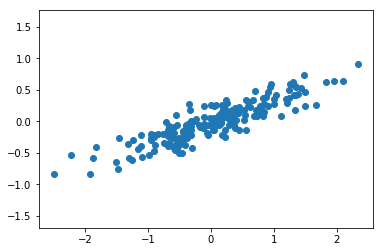

In [758]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [882]:
X = np.random.randn(200,4)

In [883]:
std = StandardScaler()
X = std.fit_transform(X)

In [884]:
pca = PCA(n_components= n_components)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 4)
transformed shape: (200, 2)


In [896]:
nips = Nipals_cpu(ncomp= n_components)
nips.fit(X)

print('Loadings P shape : ',nips.loadings.shape)
print('Score T= U @ S shape',nips.scores.shape)

X_nips=nips.transform()
print('X transfromed shape',X_nips.shape)


At step  0
T(h) shape :  (4,)
P(h) shape :  (200,)
At step  1
T(h) shape :  (4,)
P(h) shape :  (200,)
Loadings P shape :  (200, 2)
Score T= U @ S shape (4, 2)
X transfromed shape (200, 2)


In [897]:
T = nips.scores
P = nips.loadings
eig = nips.eig

In [898]:
np.testing.assert_almost_equal(np.abs(X_pca),np.abs(X_nips),decimal =1)

np.testing.assert_almost_equal(eig.values,pca.singular_values_,decimal =1)

---------------

In [835]:
# PCA WITH SVD
u, s, vh = np.linalg.svd(X.T,full_matrices=False)

np.allclose(X.T,  u @ np.diag(s)@vh)

print('Loadings u : ',u.shape)
print('vh shape',vh.shape)

# Compression k=1
Z = u[:,:1].T @ X.T 
Z.shape

Loadings u :  (4, 4)
vh shape (4, 200)


(1, 200)

---

## Test Iris dataset 

In [899]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

std =StandardScaler()
X= std.fit_transform(X)

In [869]:
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

In [872]:
nips = Nipals_cpu(ncomp=n_components)
X_nips = nips.fit_transform(X)

print('Loadings P shape : ',nips.loadings.shape)
print('Score T= U @ S shape',nips.scores.shape)

At step  0
T(h) shape :  (4,)
P(h) shape :  (150,)
At step  1
T(h) shape :  (4,)
P(h) shape :  (150,)
Loadings P shape :  (150, 2)
Score T= U @ S shape (4, 2)


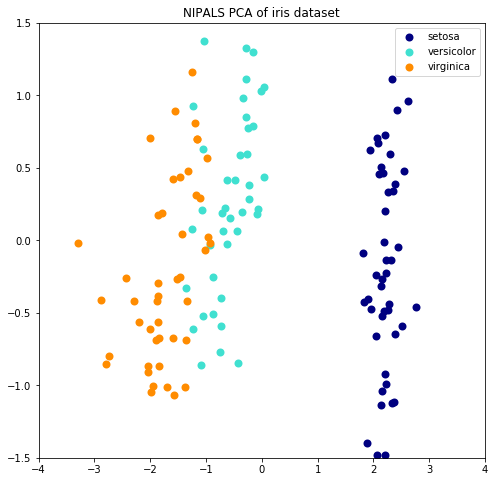

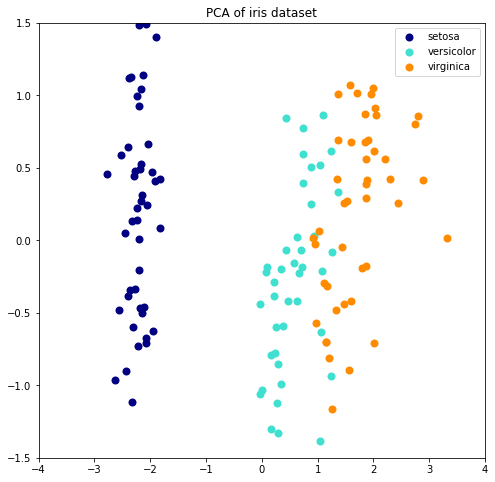

In [877]:
for X_transformed, title in [(X_nips, "NIPALS PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                    color=color, lw=2, label=target_name)

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error "
                  "%.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

In [878]:
np.testing.assert_almost_equal(np.abs(X_pca),np.abs(X_nips),decimal =2)

## GPU implementation 

### Allocate memory 
PCA model: X = T * P’ + R

* input: X, MxN matrix (data)
* input: M = number of rows in X
* input: N = number of columns in X
* input: K = number of components (K<=N)
* X = T @ P.T ( objectif)
* output: T, MxK scores matrix
* output: P, NxK loads matrix
* output: R, MxN residual matrix


In [880]:
M = 10
N = 100 
K = 2

X = np.random.randn(M,N).astype(np.float32)
P = np.empty((N,K),dtype= np.float32)
T = np.empty((M,K),dtype= np.float32)
#R = np.empty((M,N),dtype= np.float32)
# eigenvalues 
E = np.empty((K,),dtype= np.float32)

**TODO** gérer les erreurs d'allocation de mémoire 
* Transpose data ( TODO mn be3d) 
* Center the data 


In [ ]:
mod = SourceModule("""
  __global__ void onestepcomp(float *X,float *T, float *P,float *E, int M , int N, int K)
  {
    while(true):
        
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if(idx < N)
      c[idx] = a[idx] + b[idx];
      
    int J = 500;   
    double tol= 1.0e-5 ;
    
    double a, b;
    a = 0.0;
    
    for(j=0; j<J; j++) {
    
        ph = X.T.dot(th) / np.sum(th*th)
        
        cublasDgemv('t', M, N, 1.0, dR, M, &dT[k*M], 1, 0.0, &dP[k*N], 1);
       
        cublasDscal(N, 1.0/cublasDnrm2(N, &dP[k*N], 1), &dP[k*N], 1);
        
        cublasDgemv('n', M, N, 1.0, dR, M, &dP[k*N], 1, 0.0, &dT[k*M], 1);
    
        b = cublasDnrm2(M, &dT[k*M], 1);
        
        if(fabs(a - b) < er*b) break;
        a = b;
    }
  }
  """)
prog = mod.get_function("add")

prog(a_gpu, b_gpu,c_gpu, np.uint32(N),block=blockDim,grid=gridDim)


In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

import numpy as np


N = 5
BLOCKSIZE = 256


blockDim = (5, 3, 1)
gridDim = ( 1, 1, 1)


a = np.random.randn(5,3).astype(np.float32)
b = np.random.randn(5).astype(np.float32)
c = np.zeros((5,3)).astype(np.float32)

a_gpu = gpuarray.to_gpu(a)
b_gpu = gpuarray.to_gpu(b)
c_gpu = gpuarray.to_gpu(c)

mod = SourceModule("""
      #define N 5
    __global__ void mult(float *a, float *b, float *c)
    {
        int a_idx = blockIdx.x + threadIdx.x * blockDim.y;
        
        __shared__ float temp[N];
        
        temp[threadIdx] = a[a_idx] * b[threadIdx.x];
        
        __syncthreads();
        
        if (0 == threadIdx.x){ 
          int sum = 0;
            for (int i = 0; i < N; i++){sum += temp[i];}
        }
    }
    """)

prog = mod.get_function("mult")

prog(a_gpu, b_gpu,c_gpu,block=blockDim, grid=gridDim)


print(c_gpu.get())